# Setup

Import all the necessary packages.

In [1]:
import os, platform

import re
from pprint import pprint 

import pandas as pd
from pandas import Timestamp
import numpy as np
import itertools
from datetime import datetime
from pytz import timezone

import multiprocessing as mp

import seaborn as sns
import matplotlib.pyplot as plt

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

import cProfile

### Credentials

Establish my credentials for the Spotify API, and setup up an object to use for calls to the API.

In [2]:
spotify_id = 'c5c5978ddbf94927a493aaa72f9d197a'
spotify_secret = '6e531cfaa4134f1a9269cc4c0a364b1d'
REQUEST_TIMEOUT = 4

client_credentials_manager = SpotifyClientCredentials(
    client_id = spotify_id, 
    client_secret = spotify_secret)
sp = spotipy.Spotify(
    client_credentials_manager = client_credentials_manager, 
    requests_timeout = REQUEST_TIMEOUT)

# Explore

Last.FM data downloaded via https://benjaminbenben.com/lastfm-to-csv/.

Load the raw data. Notice how there are some missing album titles and timestamps. This is likely just the result of a bad script pulling from Last.FM, so we'll have to fix that. Below the counts is a random sample of the data, just to get a feel of what is in there.

In [3]:
original_history = pd.read_csv('data/alexliebscher.csv')
print(original_history.count())
original_history.sample(5)

artist       8022
album        8009
track        8022
timestamp    7983
dtype: int64


,artist,album,track,timestamp
6460,The Rolling Stones,AFTERMATH (Remastered),Paint It Black,1/3/18 19:21
1335,Vince Staples,Summertime '06,Might Be Wrong,3/11/18 23:56
418,UB40,The Very Best Of,Red Red Wine - Edit,3/21/18 0:34
3360,Tyler the Creator,Flower Boy,See You Again,2/13/18 17:12
6100,Bruno Major,A Song For Every Moon,Easily,1/8/18 3:39


Fixing missing timestamp data won't be hard, we will just backfill to take care of that. A very small percentage is missing, and I assume the missing values have a high probability of being similar to the song before.

In [4]:
original_history['timestamp'] = original_history['timestamp'].bfill()
print(original_history['timestamp'].count())

8022


The timestamps are also missing timestamp information, so we should add that to ensure our analysis reflects my local time. In this case, all timestamps are assumed to be UTC and are converted to US/Pacific, my local zone.

In [5]:
def correctTimestamp(timestamp):
    '''
    Correct missing timezone information to US/Pacific from UTC
    
    Parameters
    ----------
    timestamp : str, pandas.Timestamp
        The naive timestamp to correct
        
    Return
    ----------
    A corrected, US/Pacific aware timestamp
    '''
    if type(timestamp) is str:
        timestamp = Timestamp(datetime.strptime(timestamp, '%x %H:%M').replace(tzinfo=timezone('UTC')))
    if timestamp.tzinfo is None:
        timestamp = timestamp.tz_localize('UTC')
        
    return timestamp.tz_convert('US/Pacific')

In [6]:
timezoned_history = original_history
timezoned_history['timestamp'] = timezoned_history['timestamp'].apply(correctTimestamp)

The first song was recorded on December 18th, 2017 at roughly 7pm. This dataset covers the following 101 days after that. A random sample is available to see the corrected timestamps.

In [7]:
history_max = timezoned_history['timestamp'].max()
history_min = timezoned_history['timestamp'].min()

print(history_min)
print(history_max - history_min)
timezoned_history.sample(5)

2017-12-18 18:55:00-08:00
101 days 19:54:00


,artist,album,track,timestamp
2036,Farruko,Diles,Diles (feat. Arcangel Nengo Flow Dj Luian & Ma...,2018-03-01 18:02:00-08:00
1222,R.Lum.R,Be Honest,Be Honest,2018-03-12 17:29:00-07:00
1071,Above & Beyond,Acoustic,Satellite / Stealing Time,2018-03-14 20:28:00-07:00
1570,King Krule,6 Feet Beneath The Moon,Baby Blue,2018-03-06 23:06:00-08:00
3809,Stwo,Neither Do I,Neither Do I,2018-02-07 13:55:00-08:00


### Fetch full track data

In [8]:
delimeter_pattern = re.compile("[\{\}\[\]\(\)\#\'\"]")
classical_pattern = re.compile("((op\.?|no\.?)\s*\d{1,3}\s?)", re.IGNORECASE)
collections_pattern = re.compile("(^\d{1,3}\s*)")
stylizations_pattern = re.compile("[\,\-\:\_\&\*]\s?")

def get_track_info(track, artist, album='', id_excl=False):
    '''
    With a track name and artist, and optionally an album name,
    search for a corresponding track via the Spotify API and
    build an object with possible descriptive data.
    
    Parameters
    ----------
    track : str
        The name of a track
    artist : str
        The name of the track's artist
    album : str, optional
        The name of the track's album
    id_excl : bool, optional
        Return only the track's Spotify ID
    
    Return
    ----------
    Descriptive track data, or just the track ID, or an empty
    dict if no data could be found for the specified track
    '''
        # remove (feat. some artist) for cleaner search
    track = track.lower()
    if " (feat" in track:
        track = track.split(" (feat")[0]
    elif " (with" in track:
        track = track.split(" (with")[0]
    elif " (&" in track:
        track = track.split(" (&")[0]
        
    # clean album names too
    album = album.lower()
    if "nan" == album:
        album = ""
    elif " (feat" in album:
        album = album.split(" (feat")[0]
    elif " (with" in album:
        album = album.split(" (with")[0]
    elif " (&" in album:
        album = album.split(" (&")[0]
        
    # compose a clean, simple query string
    query = str(track + ' ' + artist + ' ' + album).strip()
    
    query = delimeter_pattern.sub("", query) # remove various delimeter chars
    query, subs = classical_pattern.subn("", query) # remove common strings in classical track titles
                                                    # unfortunately modifies tracks such as Candy Shop 
                                                    # by 50 Cent to "candy shCent"
    if subs > 0:
        # classical music often starts with the number of pieces in
        # a collection ("12 Etudes, Op. 10: No.10 in C minor")
        query = collections_pattern.sub("", query)
        
    query = stylizations_pattern.sub(" ", query) # common stylizations in track/album names
        
    # store a new track
    _track = {}
    
    # if the song exists in the Spotify catalog, fetch info
    try:
        meta = sp.search(q='track:' + query, type='track', limit=1)
        meta = meta['tracks']['items'][0]

        if not id_excl:
            features = sp.audio_features([meta['id']])[0]
            
    except Exception as e:
        # if the track could not be found, try once more without the album
        if album is not "":
            
            retry = get_track_info(track, artist)
            # if the track couldn't be found without the album, give up
            if retry:
                return retry
            
        print('no data for: {} by {} ({})'.format(track, artist, album))
        print('query: {}\n'.format(query))
        return {}

    if id_excl and meta['id']:
        return meta['id']
    
    # store relevant information and return the object
    try:
        _track['id'] = meta['id']
        _track['name'] = meta['name']
        _track['release'] = meta['album']['release_date']
        _track['popularity'] = meta['popularity']
        _track['explicit'] = int(meta['explicit'])
        _track['artists'] = [a['id'] for a in meta['artists']]
        _track['album'] = meta['album']['name']

        _track['acousticness'] = features['acousticness']
        _track['danceability'] = features['danceability']
        _track['duration_ms'] = features['duration_ms']
        _track['energy'] = features['energy']
        _track['key'] = features['key']
        _track['liveness'] = features['liveness']
        _track['loudness'] = features['loudness']
        _track['mode'] = features['mode']
        _track['speechiness'] = features['speechiness']
        _track['tempo'] = features['tempo']
        _track['time_signature'] = features['time_signature']
        _track['valence'] = features['valence']
    except TypeError:
        return {}
    
    return _track

Extract a random sample of 50 tracks. I can use this to compare single processor efficiency with multiprocessor efficiency.

In [10]:
sample = timezoned_history.sample(50)
sample.head()

,artist,album,track,timestamp
2848,Unlike Pluto,Where I Won't Be Found,Rescue Me,2018-02-19 13:13:00-08:00
3712,The Neighbourhood,Wiped Out!,Daddy Issues,2018-02-08 21:52:00-08:00
5889,BJ The Chicago Kid,In My Mind,Church,2018-01-12 10:16:00-08:00
3240,Cosmo Pyke,Social Sites,Social Sites,2018-02-14 13:05:00-08:00
1825,Jon Waltz,Backstreets,Backstreets,2018-03-03 13:27:00-08:00


## Baseline multiprocessor efficiency

Time and record serial processing and then time multiprocessor functionality. Let this be a simple measurement of how well we can do with multiprocessing when fetching track data from the API. I learned that this was the way to go, especially as fetch 5,000+ tracks multiple times during testing, and as I update my notebook. Unfortuntaly, when beginning this project, I ran `get_track_info()` over 7,400 times with serial processing and that took about an hour and 58 minutes. Never again!

In [11]:
cpus = mp.cpu_count() # used later

In [91]:
# initialize a sharedctypes integer to count records
v = mp.Value('i', 0, lock=False)

def async_fetch(track, artist, album):
    '''
    Count and display track searches and timing
    
    Parameters
    ----------
    track : str
        The name of a track
    artist : str
        The name of the track's artist
    album : str
        The name of the track's album
    
    Return
    ----------
    Data about the track, if the track is found (otherwise, empty dict)
    '''
    if v.value % 10 == 0 and v.value is not 0:
        # after every 10 tracks searched, print progress information
        print('record: #{} at ({})\n'.format(str(v.value), datetime.now() - s))
        
    v.value += 1
    return get_track_info(track, artist, album)

def serial(tracks):
    '''
    A serial processor for comparison's purpose (1 CPU, 1 process)
    
    Parameters
    ----------
    tracks : list
        A list of tracks to search
    
    Return
    ----------
    A list of track data in dicts
    '''
    return [get_track_info(str(t['track']), str(t['artist']), str(t['album'])) for i, t in tracks.iterrows()]

def multiprocess(processes, tracks):  
    '''
    Multiprocessing to utilize all cores for comparison's purpose
    
    Parameters
    ----------
    processes : int
        The number of processes to create in parallel
    tracks : list
        A list of tracks to search
    
    Return
    ----------
    A list of track data in dicts
    '''
    pool = mp.Pool(processes=processes)
    results = [pool.apply_async(async_fetch, args=(str(t['track']), str(t['artist']), str(t['album']))) for i, t in tracks.iterrows()]
    results = [p.get() for p in results]
        
    return results

print('\n')
print('# of CPUs:\t{}'.format(cpus))
print('Python version:\t{}'.format(platform.python_version()))
print('Compiler:\t{}'.format(platform.python_compiler()))
print('System:\t\t{}'.format(platform.system()))
print('Release:\t{}'.format(platform.release()))
print('Machine:\t{}'.format(platform.machine()))
print('Processor:\t{}'.format(platform.processor()))
print('Interpreter:\t{}'.format(platform.architecture()[0]))
print('\n')

# Test and time serial()
s = datetime.now()
serial_temp = pd.DataFrame(serial(sample)).dropna()
serial_t = datetime.now() - s

# Test and time multiprocess()
s = datetime.now()
multi_temp = pd.DataFrame(multiprocess(cpus, sample)).dropna()
multi_t = datetime.now() - s



# of CPUs:	4
Python version:	3.6.3
Compiler:	GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)
System:		Darwin
Release:	17.4.0
Machine:	x86_64
Processor:	i386
Interpreter:	64bit


record: #10 at (0:00:01.427131)

record: #20 at (0:00:03.175262)

record: #30 at (0:00:04.570392)

record: #40 at (0:00:06.325380)



In [92]:
print('Serial Processing')
print('search ratio (found : expected): {}'.format(len(serial_temp)/len(sample)))
print('Time: {}'.format(serial_t))
print('\nMulti Processing')
print('search ratio (found : expected): {}'.format(len(multi_temp)/len(sample)))
print('Time: {}'.format(multi_t))
print('\n{0:.2f}x faster with multiprocess'.format(serial_t / multi_t))

Serial Processing
search ratio (found : expected): 1.0
Time: 0:00:30.734235

Multi Processing
search ratio (found : expected): 1.0
Time: 0:00:10.473129

2.93x faster with multiprocess


## Fetch all track data from Spotify

Use all 4 of my CPUs to fetch track information in parallel.

In [30]:
# initialize sharedctype integers to count records
v = mp.Value('i', 0, lock=False)
total = None

def async_fetch_real(track, artist, album, timestamp):
    '''
    Count and display track searches and timing
    
    Parameters
    ----------
    track : str
        The name of a track
    artist : str
        The name of the track's artist
    album : str
        The name of the track's album
    timestamp : str
        The timestamp of the track
    
    Return
    ----------
    Data about the track, if the track is found (otherwise, empty dict)    
    '''
    if v.value % 100 == 0 and v.value is not 0:
        # after every 100 tracks searched, print progress information
        elap = datetime.now() - s
        print('record: #{} - remaining: {}\n'.format(str(v.value), ((elap/v.value) * total.value) - elap))
        
    v.value += 1
    
    _t = get_track_info(track, artist, album)
    # re-attach the timestamp to the track data
    _t.update({
        'timestamp': timestamp
    })
    
    return _t

def multiprocess(processes, tracks):
    '''
    Multiprocessing to utilize all cores for all listening history
    
    Parameters
    ----------
    processes : int
        The number of processes to create in parallel
    tracks : list
        A list of tracks to search
    
    Return
    ----------
    A list of track data in dicts    
    '''
    pool = mp.Pool(processes=processes)
    results = [pool.apply_async(async_fetch_real, args=(str(t['track']), str(t['artist']), str(t['album']), str(t['timestamp']),)) for i, t in tracks.iterrows()]
    results = [p.get() for p in results]
    
    return results

def updateTracks(original, unique):
    '''
    Fetch track data via the Spotify API and save the compiled output to JSON
    
    Parameters
    ----------
    original : pandas.DataFrame
    unique : pandas.DataFrame
    '''
    s = datetime.now()
    temp = pd.DataFrame(multiprocess(cpus, unique)).dropna()
    multi_t = datetime.now() - s
    
    if not temp.empty:
        compiled = pd.concat([original, temp])
        compiled.to_json('data/history_comp.json')
        print('Saved complete history')
        
        print('Search ratio (found : expected): {}'.format(len(temp)/total.value))
        print('Total time:\t\t\t {}'.format(multi_t))
        print('Songs/sec fetched:\t\t {}'.format(total.value/multi_t.total_seconds()))
    else:
        print('No new track data found')

In [31]:
last_full_history = pd.read_json('data/history_comp_3_28.json')
last_full_history['timestamp'] = last_full_history['timestamp'].apply(correctTimestamp)
last_full_history = pd.DataFrame(columns=last_full_history.columns)

if last_full_history.empty or last_full_history['timestamp'].max() < timezoned_history['timestamp'].max():
    unique = timezoned_history[~timezoned_history['timestamp'].isin(last_full_history['timestamp'])]
    
    total = mp.Value('i', len(unique), lock=False)
    
    updateTracks(last_full_history, unique)
else:
    print('all records updated')
    
# Saved complete history
# Search ratio (found : expected): 0.9907753677387185
# Total time:			 0:24:29.376252
# Songs/sec fetched:		 5.459459406044627

record: #100 - remaining: 1 day, 5:12:28.151442

no data for: stampede - original mix by Dimitri Vegas & Like Mike ()
query: stampede  original mix Dimitri Vegas  Like Mike

no data for: stampede - original mix by Dimitri Vegas & Like Mike (stampede)
query: stampede  original mix Dimitri Vegas  Like Mike stampede

no data for: stayin' alive - 2007 remastered version saturday night fever by Bee Gees ()
query: stayin alive  2007 remastered version saturday night fever Bee Gees

no data for: stayin' alive - 2007 remastered version saturday night fever by Bee Gees (saturday night fever [the original movie soundtrack])
query: stayin alive  2007 remastered version saturday night fever Bee Gees saturday night fever the original movie soundtrack

no data for: clockscared - livefromspotifylondon by The Parcels ()
query: clockscared  livefromspotifylondon The Parcels

record: #200 - remaining: 14:35:02.750087

retrying ...2secs
retrying ...2secs
retrying ...2secs
retrying ...1secs
retrying ...1s


no data for: come back for you by Elefante (come back for you)
query: come back for you Elefante come back for you

no data for: d.i.a. by Cam'ron ()
query: d.i.a. Camron

no data for: d.i.a. by Cam'ron (d.i.a.)
query: d.i.a. Camron d.i.a.

record: #2600 - remaining: 1:01:53.044669

record: #2700 - remaining: 0:59:04.302661

retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
record: #2800 - remaining: 0:56:27.862524

no data for: catching on by Elefante ()
query: catching on Elefante

no data for: catching on by Elefante (i am the elephante)
query: catching on Elefante i am the elephante

retrying ...2secs
retrying ...2secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
no data for: a little more time by Zox ()
query: a little more time Zox

no data for: a little more time by Zox (the wait)
query: a little more time Zox the wait

record: #2900 - remaining: 0:54:01.3050

query: age of innocence hellberg remix Elefante

no data for: clockscared - livefromspotifylondon by The Parcels ()
query: clockscared  livefromspotifylondon The Parcels

retrying ...2secs
retrying ...2secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
record: #4900 - remaining: 0:23:22.592135

retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
record: #5000 - remaining: 0:22:21.224986

record: #5100 - remaining: 0:21:20.810310

no data for: clockscared - livefromspotifylondon by The Parcels ()
query: clockscared  livefromspotifylondon The Parcels

retrying ...2secs
retrying ...2secs
retrying ...2secs
retrying ...1secs
retrying ...1secs
no data for: strange things by B.Lewis ()
query: strange things B.Lewis

no data for: strange things by B.Lewis (strange things)
query: strange things B.Lewis strange things

retrying ...2secs
retrying ...1secs
retrying ...1secs
retryin


record: #7000 - remaining: 0:06:17.303045

no data for: keep their heads ringin' - lp version; by Dr. Dre ()
query: keep their heads ringin  lp version; Dr. Dre

no data for: keep their heads ringin' - lp version; by Dr. Dre (keep their heads ringin')
query: keep their heads ringin  lp version; Dr. Dre keep their heads ringin

no data for: in and out by Blonker ()
query: in and out Blonker

no data for: in and out by Blonker (in and out)
query: in and out Blonker in and out

no data for: loud(y) by Lewis Del Mar ()
query: loudy Lewis Del Mar

no data for: loud(y) by Lewis Del Mar (loud(y))
query: loudy Lewis Del Mar loudy

retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
no data for: afterlife (dabin remix) [feat. echos] by Illenium ()
query: afterlife dabin remix feat. echos Illenium

no data for: afterlife (dabin remix) [feat. echos] by Illenium (ashes (remixes))
query: afterlife dabin rem

In [32]:
full_history = pd.read_json('data/history_comp.json')
full_history['timestamp'] = full_history['timestamp'].apply(correctTimestamp)
full_history

,acousticness,album,artists,danceability,duration_ms,energy,explicit,id,key,liveness,loudness,mode,name,popularity,release,speechiness,tempo,time_signature,timestamp,valence
0,0.000196,Invincible EP,[0PxzGnCYBpSuaI49OR94cA],0.694,220000,0.4830,0,2sKTYRCgUHXmIhI2hoBuZE,0,0.1340,-7.157,1,When I Get There,64,2017-02-10,0.0359,96.029,4,2018-03-30 15:49:00-07:00,0.1320
1,0.258000,Silence (SUMR CAMP Remix),"[64KEffDW9EtZ1y2vBYgq8T, 6LuN9FCkKOj5PcnpouEgn...",0.639,223107,0.7700,0,2Z8S3qGTjLtGNsdU0xiF1B,1,0.2020,-5.924,0,Silence - SUMR CAMP Remix,57,2017-10-12,0.1730,120.970,4,2018-03-30 15:46:00-07:00,0.3010
10,0.646000,Sunflower,[7pbDxGE6nQSZVfiFdq9lOL],0.384,252231,0.7650,1,4EpZ4eYuZOwPSSwyqpdHnJ,6,0.5220,-4.463,1,Sunflower,75,2017-03-22,0.0579,129.903,4,2018-03-30 15:10:00-07:00,0.5670
100,0.057200,Let Go,[0p4nmQO2msCgU4IF37Wi3j],0.585,244507,0.7760,0,5xEM5hIgJ1jjgcEBfpkt2F,5,0.3000,-5.898,1,Complicated,78,2002-09-06,0.0459,77.987,4,2018-03-28 11:51:00-07:00,0.4270
1000,0.192000,Young Fel,"[2848adRcxvgWNRcz1g1tQD, 6yrnKnj4fIE0RlanJ1iFTI]",0.656,237480,0.4070,1,5w3jub5KDtlZE6Jd45gRYn,7,0.1980,-8.163,0,Desert Eagle (feat. GYYPS),56,2016-07-22,0.4150,113.752,4,2018-03-15 21:15:00-07:00,0.4420
1001,0.011600,2 Heartless,"[3tJoFztHeIJkJWMrx0td2f, 0VRj0yCOv2FXJNP47XQnx5]",0.924,197101,0.7190,1,26OdQ5Qd7HJg6hNXIa7EHc,2,0.1470,-5.411,1,Bagg Move (feat. Quavo),66,2018-02-14,0.2990,140.020,4,2018-03-15 21:12:00-07:00,0.6610
1002,0.151000,Make It Right (featuring Joji),"[6POMCYQE1sq1BJ8FnAvTA8, 3MZsBdqDrRTJihTHQrO6Dq]",0.759,226800,0.5310,1,5RbyjavvdfTArV0N9BVsb9,1,0.1110,-7.125,0,Make It Right,54,2018-02-23,0.0719,146.016,4,2018-03-15 21:07:00-07:00,0.6850
1003,0.293000,We Don't Luv Em (Remix),"[1ZLO8d7zll1WeQJUHaxQer, 13y7CgLHjMVRMDqxdx0Xd...",0.896,193776,0.6150,1,2Y43TDqgnRgVZA7RxtxEV1,6,0.1220,-9.326,0,We Don't Luv Em (Remix),75,2018-02-09,0.3260,140.040,4,2018-03-15 21:04:00-07:00,0.8900
1004,0.080200,I Want You,"[2o5jDhtHVPhrJdv3cEQ99Z, 3IpvVrP3VLhruTmnququq7]",0.680,173810,0.8670,0,4I1zD6WvoJoLDFWsqcCpMJ,7,0.0734,-5.128,0,I Want You,65,2016-08-05,0.0437,126.078,4,2018-03-15 21:01:00-07:00,0.2860
1005,0.002080,Stamped - EP,[1P7AnOEEUS1nyAgRNfHjuV],0.714,147692,0.6190,1,6AOc70CUv15fViWyGNCIzA,8,0.1350,-8.246,0,Hou to Yyz,34,2018-02-13,0.0456,130.010,4,2018-03-15 21:01:00-07:00,0.1830


The service to export Last.FM data overcounts the most recently listened to song, so I choose to keep the first quarter of instances and drop the remainder. This prevents an artificial skewing toward a song that shouldn't be the mode of the data set. Drawback: if the first song _really_ is the mode of the dataset, I unknowingly change that.

In [33]:
track_mode = full_history['id'].mode()[0]
L = list(full_history.loc[full_history['id'] == track_mode].index)
L = L[int(len(L)*0.25):]
print(full_history.loc[L[0]]['name'])
L

I Want You


[2612,
 2813,
 3014,
 3215,
 3416,
 3617,
 3818,
 401,
 4019,
 4220,
 4421,
 4622,
 4823,
 5024,
 5225,
 5426,
 5627,
 5828,
 602,
 6029,
 6230,
 6431,
 6632,
 6833,
 7034,
 7235,
 7436,
 7637,
 7838,
 803]

In [34]:
full_history = full_history.drop(index=L)
full_history.head()

,acousticness,album,artists,danceability,duration_ms,energy,explicit,id,key,liveness,loudness,mode,name,popularity,release,speechiness,tempo,time_signature,timestamp,valence
0,0.000196,Invincible EP,[0PxzGnCYBpSuaI49OR94cA],0.694,220000,0.483,0,2sKTYRCgUHXmIhI2hoBuZE,0,0.134,-7.157,1,When I Get There,64,2017-02-10,0.0359,96.029,4,2018-03-30 15:49:00-07:00,0.132
1,0.258000,Silence (SUMR CAMP Remix),"[64KEffDW9EtZ1y2vBYgq8T, 6LuN9FCkKOj5PcnpouEgn...",0.639,223107,0.770,0,2Z8S3qGTjLtGNsdU0xiF1B,1,0.202,-5.924,0,Silence - SUMR CAMP Remix,57,2017-10-12,0.1730,120.970,4,2018-03-30 15:46:00-07:00,0.301
10,0.646000,Sunflower,[7pbDxGE6nQSZVfiFdq9lOL],0.384,252231,0.765,1,4EpZ4eYuZOwPSSwyqpdHnJ,6,0.522,-4.463,1,Sunflower,75,2017-03-22,0.0579,129.903,4,2018-03-30 15:10:00-07:00,0.567
100,0.057200,Let Go,[0p4nmQO2msCgU4IF37Wi3j],0.585,244507,0.776,0,5xEM5hIgJ1jjgcEBfpkt2F,5,0.300,-5.898,1,Complicated,78,2002-09-06,0.0459,77.987,4,2018-03-28 11:51:00-07:00,0.427
1000,0.192000,Young Fel,"[2848adRcxvgWNRcz1g1tQD, 6yrnKnj4fIE0RlanJ1iFTI]",0.656,237480,0.407,1,5w3jub5KDtlZE6Jd45gRYn,7,0.198,-8.163,0,Desert Eagle (feat. GYYPS),56,2016-07-22,0.4150,113.752,4,2018-03-15 21:15:00-07:00,0.442


As shown below, for every 18 songs listened to, 10 of them are new to my music catalog.

In [35]:
unique_history = full_history.drop('timestamp', axis=1)
unique_history = unique_history.drop_duplicates('id')
len(full_history)/len(unique_history)

1.8315984270182744

In [36]:
def makeWeekday(a):
    '''
    weekday
    '''
    return a.weekday()

In [37]:
full_history['weekday'] = full_history['timestamp'].apply(makeWeekday)

In [38]:
def makeDecimalHour(a):
    '''
    decimal hour
    '''
    return a.hour + (a.minute / 60.0)

In [39]:
full_history['hour_decimal'] = full_history['timestamp'].apply(makeDecimalHour)

In [40]:
def _averageDatetimeFrequency(df, hour_inc):
    hour_bins = np.arange(0, 24, hour_inc)
    hour_labels = np.arange(hour_inc, 24, hour_inc)

    df['time_bin'] = pd.cut(df['hour_decimal'], bins=hour_bins, labels=hour_labels)

    history_time_bivar = df.groupby(['weekday', 'time_bin'], axis=0)
    return history_time_bivar.size().unstack()

def plotAverageDatetimeFrequency(data, title='', fs=(12,5), hour_inc=0.5):
    plt.subplots(figsize=fs)
    plt.title('Average Listening Date-time Frequency{}'.format(title))
    g = sns.heatmap(_averageDatetimeFrequency(data, hour_inc), cmap="Blues", robust=True)
    g.set(yticklabels=['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']); # use ; to suppress output

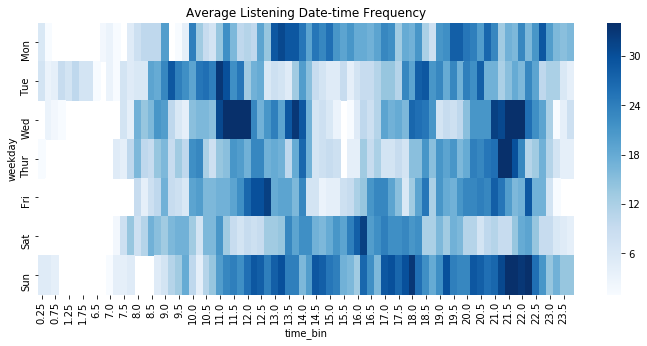

In [42]:
plotAverageDatetimeFrequency(full_history, hour_inc=0.25)

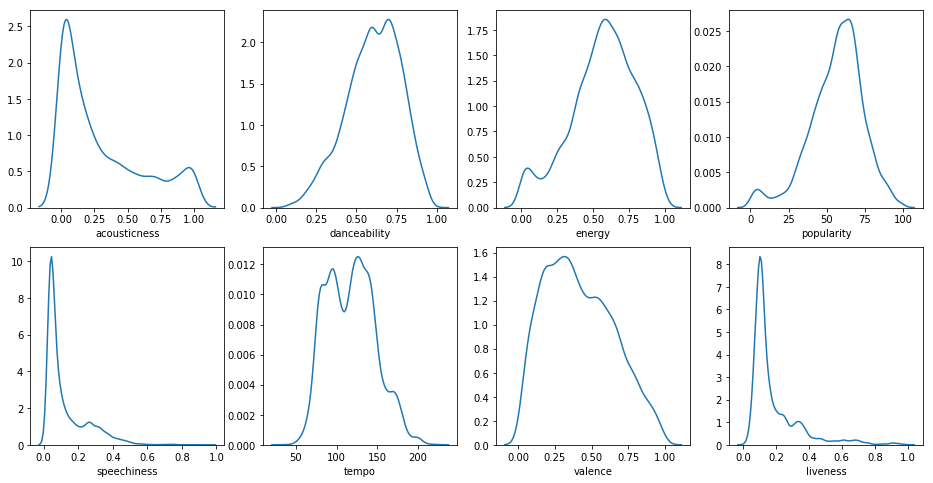

In [43]:
plt.subplots(figsize=(16,8))
plt.subplot(241)
sns.distplot(full_history['acousticness'], hist=False)
plt.subplot(242)
sns.distplot(full_history['danceability'], hist=False)
plt.subplot(243)
sns.distplot(full_history['energy'], hist=False)
plt.subplot(244)
sns.distplot(full_history['popularity'], hist=False)
plt.subplot(245)
sns.distplot(full_history['speechiness'], hist=False)
plt.subplot(246)
sns.distplot(full_history['tempo'], hist=False)
plt.subplot(247)
sns.distplot(full_history['valence'], hist=False)
plt.subplot(248)
sns.distplot(full_history['liveness'], hist=False)

In [44]:
top_25_ids = [i for i in full_history['id'].value_counts().nlargest(25).index]
top_25 = unique_history[unique_history['id'].isin(top_25_ids)]

top_25

,acousticness,album,artists,danceability,duration_ms,energy,explicit,id,key,liveness,loudness,mode,name,popularity,release,speechiness,tempo,time_signature,valence
1006,0.054100,Two Shots (feat. gnash),"[1iH2Yx2Ea0kZ0zKI3Nlk30, 3iri9nBFs9e4wN7PLIetAw]",0.768,179897,0.4080,1,4LtUbIyBlc1PbK0w1Q244V,4,0.1130,-8.550,0,Two Shots (feat. gnash),69,2018-02-02,0.0713,129.979,4,0.0875
1031,0.371000,Flower Boy,"[4V8LLVI7PbaPR0K2TGSxFF, 1U1el3k54VvEUzo3ybLPlM]",0.558,180387,0.5590,1,7KA4W4McWYRpgf0fWsJZWB,6,0.1090,-9.222,1,See You Again,80,2017-07-21,0.0959,78.558,4,0.6200
1044,0.716000,dont smile at me,[6qqNVTkY8uBg9cP3Jd7DAH],0.499,203569,0.4140,0,41zXlQxzTi6cGAjpOXyLYH,7,0.1150,-8.457,1,idontwannabeyouanymore,72,2017-12-22,0.0439,170.101,3,0.2730
1139,0.000104,The Neighbourhood,[77SW9BnxLY8rJ0RciFqkHh],0.597,224027,0.6250,0,1w553LQgqi5Wr1EbnPe2bB,1,0.1490,-5.940,1,Scary Love,72,2018-03-09,0.0308,112.026,4,0.1460
1160,0.003580,Bitch I'm the Shit 2,"[5LHRHt1k9lMyONurDHEdrp, 5K4W6rqBFWDnAN6FQUkS6x]",0.526,199447,0.5910,1,17llIOFatQMmTeja67zbaq,1,0.9050,-6.326,1,Feel Me,47,2017-07-21,0.1240,141.697,4,0.1570
1223,0.090500,Get You - Single,[20wkVLutqVOYrc0kxFs7rA],0.707,270847,0.2380,1,1boXOL0ua7N2iCOUVI1p9F,3,0.0842,-8.818,1,Japanese Denim,77,2016-10-21,0.0379,124.156,3,0.3450
1225,0.453000,Neither Do I,"[5WQxQAu4xmUwCzxPw3GiB4, 3KV3p5EY4AvKxOlhGHORLg]",0.812,220000,0.3980,1,4IYmJKwEsFTwQUdzsWSiv1,9,0.1200,-9.832,0,Neither Do I,67,2017-10-20,0.1050,119.955,4,0.1890
1245,0.847000,SATURATION II,[1Bl6wpkWCQ4KVgnASpvzzA],0.497,204939,0.5500,1,66dQdXAbtuPdSasezCQVZE,8,0.1190,-6.130,1,SUMMER,65,2017-08-25,0.0257,79.955,4,0.5420
1274,0.062700,Where I Won't Be Found,[6fcTRFpz0yH79qSKfof7lp],0.482,264010,0.6700,0,5L4VOsq8v9HxxyuSZosBNU,2,0.1270,-4.705,0,Slow Dive,55,2017-06-26,0.0440,149.992,4,0.1510
1340,0.542000,dont smile at me,[6qqNVTkY8uBg9cP3Jd7DAH],0.525,170852,0.4050,0,1RGasjWLZ4qMN7wbtkLa3u,11,0.1140,-8.788,0,my boy,72,2017-12-22,0.2640,90.005,4,0.3630


In [45]:
artists = pd.read_json('data/artist_info.json')
artists.head()

,artist,followers,genres,id,popularity
0,Bill Evans Trio,46455,"[bebop, contemporary post-bop, cool jazz, hard...",3VEG6gxFIMfl4Cdog26avS,54
1,Jonny Lang,101002,"[blues, blues-rock, electric blues, modern blu...",5rX1EodZfwxmW4fQX2Caot,50
10,Mr FijiWiji,35442,"[brostep, catstep, chillstep, complextro, edm,...",2uEo8Rajpdz1AqineCVLHq,52
100,Bo Mason,310,[],7aAvXskSLn6pIHMUR1fHdP,24
1000,MC Ren,95546,"[gangster rap, hip hop, rap, west coast rap]",4fbyGOEjViyE97W58eGEgU,54


In [46]:
missing_artist_ids = []

for i, r in full_history.iterrows():
    for artist in r['artists']:
        if not (artists['id'] == artist).any():
            missing_artist_ids.append(artist)
            
len(missing_artist_ids)

28

In [47]:
def get_artist_info(id):
    try:
        result = sp.artist(id)
    except:
        return {}
    
    return {'artist': result['name'],
            'id': result['id'], 
            'genres': np.array(result['genres']), 
            'popularity': result['popularity'], 
            'followers': result['followers']['total']}

In [48]:
# initialize a sharedctypes integer to count records
v = mp.Value('i', 0, lock=False)
total = mp.Value('i', len(missing_artist_ids), lock=False)

cpus = mp.cpu_count()

def async_fetch_real(id):
    '''
    count and display artist searches and timing
    '''
    if v.value % 100 == 0 and v.value is not 0:
        print('record: #{}'.format(v.value))
        elap = datetime.now() - s
        print('time remaining: {}'.format(((elap/v.value) * total.value) - elap))
        
    v.value += 1
    
    return get_artist_info(id)

def multiprocess(processes, ids):
    '''
    multiprocessing to utilize all cores
    '''
    pool = mp.Pool(processes=processes)
    results = [pool.apply_async(async_fetch_real, args=(str(i),)) for i in ids]
    results = [p.get() for p in results]
    return results

s = datetime.now()
artists_temp = pd.DataFrame(multiprocess(cpus, missing_artist_ids)).dropna()
multi_t = datetime.now() - s

stitched_artists = artists.append(artists_temp, ignore_index=True)
stitched_artists = stitched_artists.drop_duplicates('id')

if not artists_temp.empty:
    stitched_artists.to_json('data/artist_info.json'.format(s.month, s.day))
    print('Saved artist info')
    
print('{} artists added (expected {})'.format(len(stitched_artists)-len(artists), len(artists_temp)))

New Artists Info: True
Saved artist info
28 artists added (expected 28)


In [49]:
collective_genres = []
for genre in stitched_artists['genres']:
    collective_genres.append(genre)
    
collective_genres = np.array(list(itertools.chain(*collective_genres)))

/Users/alex/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


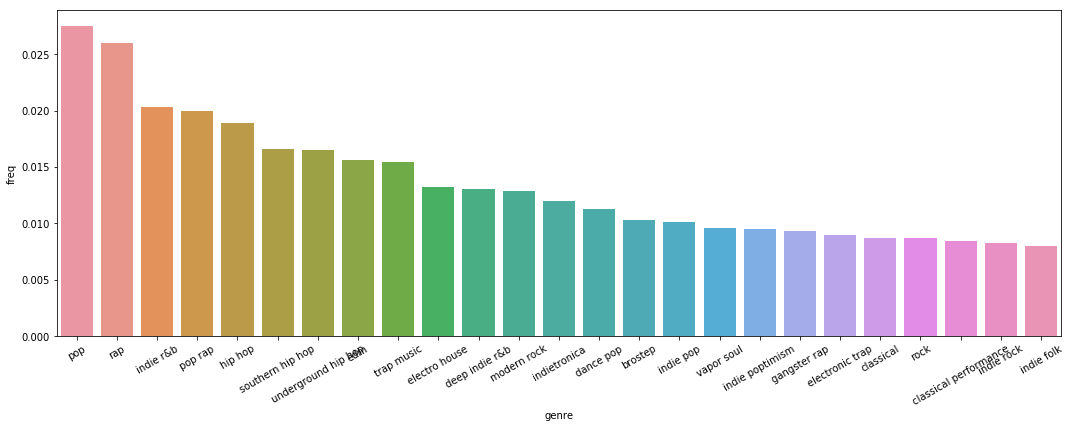

In [90]:
unique_genres, genre_counts = np.unique(collective_genres, return_counts=True)

genre_df = pd.DataFrame({'genre': unique_genres, 'freq': genre_counts/genre_counts.sum()})
sort_genre_df = genre_df.sort_values('freq', ascending=False)[:25]

plt.subplots(figsize=(18,6))
g = sns.barplot(x='genre', y='freq', data=sort_genre_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30);

In [51]:
def addTrackGenres(row):
    inner_gs = []
        
    # for each artist in a track
    for track_artist in row['artists']:
        
        # if there is any artist data for that artist
        if (stitched_artists['id'] == track_artist).any():
            
            # collect genres from artists that match the current one
            for genre in stitched_artists[stitched_artists['id'] == track_artist]['genres']:
                inner_gs.append(genre)
                
        
    row['genres'] = np.unique(list(itertools.chain(*inner_gs)))
    return row

In [52]:
# create a temp history
full_history_g = full_history

full_history_g = full_history_g.apply(addTrackGenres, 1)
full_history_g.head()

,acousticness,album,artists,danceability,duration_ms,energy,explicit,id,key,liveness,...,release,speechiness,tempo,time_signature,timestamp,valence,weekday,hour_decimal,time_bin,genres
0,0.000196,Invincible EP,[0PxzGnCYBpSuaI49OR94cA],0.694,220000,0.483,0,2sKTYRCgUHXmIhI2hoBuZE,0,0.134,...,2017-02-10,0.0359,96.029,4,2018-03-30 15:49:00-07:00,0.132,4,15.816667,16.00,"[electronic trap, vapor soul, vapor twitch]"
1,0.258000,Silence (SUMR CAMP Remix),"[64KEffDW9EtZ1y2vBYgq8T, 6LuN9FCkKOj5PcnpouEgn...",0.639,223107,0.770,0,2Z8S3qGTjLtGNsdU0xiF1B,1,0.202,...,2017-10-12,0.1730,120.970,4,2018-03-30 15:46:00-07:00,0.301,4,15.766667,16.00,"[brostep, indie r&b, pop, progressive electro ..."
10,0.646000,Sunflower,[7pbDxGE6nQSZVfiFdq9lOL],0.384,252231,0.765,1,4EpZ4eYuZOwPSSwyqpdHnJ,6,0.522,...,2017-03-22,0.0579,129.903,4,2018-03-30 15:10:00-07:00,0.567,4,15.166667,15.25,[indie r&b]
100,0.057200,Let Go,[0p4nmQO2msCgU4IF37Wi3j],0.585,244507,0.776,0,5xEM5hIgJ1jjgcEBfpkt2F,5,0.300,...,2002-09-06,0.0459,77.987,4,2018-03-28 11:51:00-07:00,0.427,2,11.850000,12.00,"[canadian pop, candy pop, dance pop, pop, pop ..."
1000,0.192000,Young Fel,"[2848adRcxvgWNRcz1g1tQD, 6yrnKnj4fIE0RlanJ1iFTI]",0.656,237480,0.407,1,5w3jub5KDtlZE6Jd45gRYn,7,0.198,...,2016-07-22,0.4150,113.752,4,2018-03-15 21:15:00-07:00,0.442,3,21.250000,21.25,"[deep underground hip hop, underground hip hop]"


In [76]:
def genreFilter(history, genres):
    '''
    filter
    '''
    indices = []

    for i, r in history.iterrows():
        if type(genres) is list:
            for genre in genres:
                if genre in r['genres']:
                    indices.append(i)
                    break
        elif type(genres) is str:
            if genres in r['genres']:
                indices.append(i)
            
    if not indices:
        raise Exception('No tracks found for genre: {}'.format(genres))

    return history[history.index.isin(indices)]

/Users/alex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  # Remove the CWD from sys.path while we load stuff.
/Users/alex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


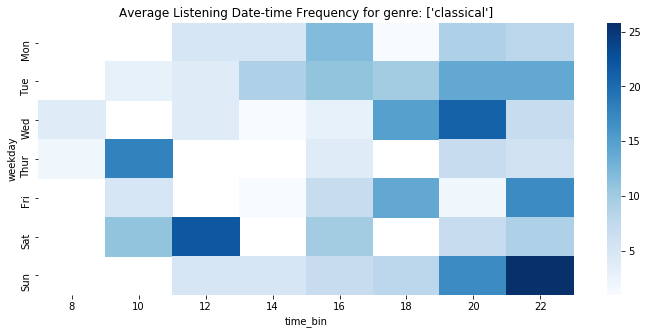

In [89]:
genre = ['classical']

genre_full_history = genreFilter(full_history_g, genre)

plotAverageDatetimeFrequency(genre_full_history, ' for genre: {}'.format(genre), hour_inc=2)